[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/polislizarralde/PythonPlayground/blob/main/docs/PlagueProject/FittingMetapopModelPlague.ipynb)

In [32]:
%matplotlib inline


In [33]:
%load_ext autoreload
%autoreload 3


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Python 3.11.2
from funct_process_data import *  # Import all functions from funct_process_data.py


Processing the data

In [35]:
# Set the working directory for private files
data_private_folder = "data/private"
southeast_path = os.path.join(data_private_folder, 'southeastScania.csv')
southeastScania = pd.read_csv(southeast_path, sep=',')

# Convert WKT (Well-Known Text) geometry to Shapely geometry
southeastScania['geometry'] = southeastScania['geometry'].apply(wkt.loads)

# Create a GeoDataFrame from the DataFrame
southeastScania = gpd.GeoDataFrame(southeastScania, geometry='geometry')
type(southeastScania)


geopandas.geodataframe.GeoDataFrame

In [36]:
# replaced all the occurences of 'UNDEFINED' and '?' with np.nan in our dataframe
southeastScania = southeastScania.replace(['UNDEFINED', '?'], np.nan)


In [37]:
southeastScania['BeginPlaguePeriod'] = pd.to_datetime(
    southeastScania['BeginPlaguePeriod'], format='%b %Y')
southeastScania['EndPlaguePeriod'] = pd.to_datetime(
    southeastScania['EndPlaguePeriod'], format='%b %Y')
southeastScania.sort_values(by=['BeginPlaguePeriod'],   # Row or columns names to sort by
                            axis=0,       # Sort Rows axis = 0
                            ascending=True,  # Sort ascending or descending?
                            # Modify the DataFrame in place (do not create a new object)
                            inplace=True
                            )

southeastScania.reset_index(drop=True, inplace=True)


In [38]:
# Create a new column called "BeginDaysPlague"
southeastScania["BeginDaysPlague"] = southeastScania.apply(
    # axis = 1 means apply function to each row
    lambda row: begin_days_between(southeastScania["BeginPlaguePeriod"].iloc[0], row["BeginPlaguePeriod"]), axis=1
)

# Create a new column called "EndDaysPlague"
southeastScania['EndDaysPlague'] = southeastScania.apply(lambda row: end_days_between(
    southeastScania['BeginPlaguePeriod'].iloc[0], row['EndPlaguePeriod']) if pd.notna(row['EndPlaguePeriod']) else None, axis=1)


In [39]:
# Replace NaN values with a value in some columns (e.g., 0)
southeastScania['BeginDaysPlague'].fillna(0, inplace=True)
southeastScania['EndDaysPlague'].fillna(0, inplace=True)
southeastScania['VictimsNumber'].fillna(0, inplace=True)

# Changing the type of some columns from float to integer
southeastScania['BeginDaysPlague'] = southeastScania['BeginDaysPlague'].astype(
    int)
southeastScania['EndDaysPlague'] = southeastScania['EndDaysPlague'].astype(int)
southeastScania['VictimsNumber'] = southeastScania['VictimsNumber'].astype(int)


Initializing the number of patches (n), the population size (patchPop) and the initial conditions for each variable (S0, E0, I0, R0, D0):

In [40]:
class Input_Model:
    def __init__(self, gdf):
        self.gdf = gdf
        self.n = self.numPatches()
        self.E0 = np.zeros(self.n)
        self.I0 = np.zeros(self.n)
        self.I0[0] = 1.0
        self.R0 = np.zeros(self.n)
        self.D0 = np.zeros(self.n)
        self.S0 = np.zeros(self.n)
        for i in range(self.n):
            self.S0[i] = self.patchPop()[i] - self.E0[i] - \
                self.I0[i] - self.R0[i]

    def patchNames(self, column_name: str = 'ParishName'):
        return self.gdf[column_name].values

    def numPatches(self):
        return len(self.patchNames())

    def patchPop(self, column_pop: str = 'BEF1699'):
        return self.gdf[column_pop].values

    def maxDays(self, column_EndDays: str = 'EndDaysPlague'):
        return self.gdf[column_EndDays].max()


Getting the centroid of each polygon for defining the transmission matrix.

In [41]:
southeastScania = get_centroid(southeastScania)


In [42]:
# Defining the seasonal transmission rate
def gaussian(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))


def seasonal_transmission_rate(t, bump_center, bump_width, bump_height):
    return bump_height * gaussian(t % 365, bump_center, bump_width) + bump_height * gaussian(t % 365 - 365, bump_center, bump_width) + bump_height * gaussian(t % 365 + 365, bump_center, bump_width)


In [43]:
def transmission_matrix(gdf: gpd.GeoDataFrame, t, beta: float, p: float, bump_center: float, bump_width: float, bump_height: float, column_geometry: str = 'geometry', column_centroid: str = 'centroid', column_pop: str = 'BEF1699', column_name: str = 'ParishName'):
    m = len(gdf)
    matrix = np.zeros((m, m))
    for i in range(m):
        polygon_i = gdf.iloc[i][column_geometry]
        centroid_i = gdf.loc[i][column_centroid]
        pop_i = gdf.iloc[i][column_pop]
        name_i = gdf.iloc[i][column_name]
        for j in range(m):
            polygon_j = gdf.iloc[j][column_geometry]
            centroid_j = gdf.loc[j][column_centroid]
            pop_j = gdf.iloc[j][column_pop]
            name_j = gdf.iloc[j][column_name]
            if i == j or name_i == name_j:
                matrix[i][j] = beta + \
                    seasonal_transmission_rate(
                        t, bump_center, bump_width, bump_height)
            else:
                if i != j and polygon_i != polygon_j and polygon_i.intersects(polygon_j):
                    distance_i_j = centroid_i.distance(centroid_j)
                    matrix[i][j] = p * (pop_i*pop_j) / ((distance_i_j)**2)
                else:
                    matrix[i][j] = 0
    return matrix


Generating the differential equations

In [44]:
def SEIRD_model(y, t, model_parameters: tuple[dict]):

    parameters = model_parameters[0]
    gdf: gpd.GeoDataFrame = parameters['gdf']
    beta: float = parameters['beta']
    p: float = parameters['p']
    gamma: float = parameters['gamma']
    sigma: float = parameters['sigma']
    bump_center: float = parameters['bump_center']
    bump_width: float = parameters['bump_width']
    bump_height: float = parameters['bump_height']
    mu: float = parameters['mu']
    N = parameters['N']
    n: int = parameters['n']

    S = defaultdict(float)
    E = defaultdict(float)
    I = defaultdict(float)
    R = defaultdict(float)
    D = defaultdict(float)

    vars = tuple(sum([[S[i], E[i], I[i], R[i], D[i]] for i in range(n)], []))
    vars = y

   # Choosing the corresponding output for each subpopulation
    def entryS(i):
        return vars[5 * i]

    def entryE(i):
        return vars[5 * i + 1]

    def entryI(i):
        return vars[5 * i + 2]

    def entryR(i):
        return vars[5 * i + 3]

    def entryD(i):
        return vars[5 * i + 4]

    # Initializando the directory for each subpopulation
    dS = {}
    dE = {}
    dI = {}
    dR = {}
    dD = {}

    # Defining the differential equations for each subpopulation
    for i in range(n):
        dS[i] = - entryS(i) / (N[i]*1.0) * sum(transmission_matrix(gdf, t, beta, p,
                                                                   bump_center, bump_width, bump_height)[i][j] * entryI(j) for j in range(n))
        dE[i] = entryS(i) / (N[i]*1.0) * sum(transmission_matrix(gdf, t, beta, p, bump_center,
                                                                 bump_width, bump_height)[i][j] * entryI(j) for j in range(n)) - sigma * entryE(i)
        dI[i] = sigma * entryE(i) - gamma * entryI(i)
        dR[i] = gamma * (1 - mu) * entryI(i)
        dD[i] = gamma * mu * entryI(i)

    derivates = sum([[dS[i], dE[i], dI[i], dR[i], dD[i]]
                    for i in range(n)], [])
    return derivates   # For odeint


def generate_sol(genInput: dict) -> dict:
    init = genInput['init']
    n = genInput['n']

    # Initial conditions vector for the metapopulation model. len(initConditions) = 5*n
    initConditions = tuple(sum(
        [[init['S'][i], init['E'][i], init['I'][i], init['R'][i], init['D'][i]] for i in range(n)], []))

    # Time vector
    T = genInput['T']
    t = np.linspace(0, T, T+1)

    # Computing the numerical solution
    model = genInput['model']
    solution = scipy.odeint(model, initConditions, t, args=((genInput,),))

    indexVar = {}
    indexVar['S'] = 0
    indexVar['E'] = 1
    indexVar['I'] = 2
    indexVar['R'] = 3
    indexVar['D'] = 4

    def varSol(patch, var):
        return solution[:, 5*patch + indexVar[var]]

    return {'S': {patch: varSol(patch, 'S') for patch in range(n)},
            'E': {patch: varSol(patch, 'E') for patch in range(n)},
            'I': {patch: varSol(patch, 'I') for patch in range(n)},
            'R': {patch: varSol(patch, 'R') for patch in range(n)},
            'D': {patch: varSol(patch, 'D') for patch in range(n)},
            'N': genInput['N'],
            'init': init,
            'beta': genInput['beta'],
            'p': genInput['p'],
            'gamma': genInput['gamma'],
            'sigma': genInput['sigma'],
            'mu':  genInput['mu'],
            't': t,
            'n': n,
            'bump_center': genInput['bump_center'],
            'bump_width': genInput['bump_width'],
            'bump_height': genInput['bump_height'],
            'model': model,
            'raw_solution': solution}


Trying a small dataframe

In [57]:
k = 4
example = southeastScania.head(k)
example.shape
m = Input_Model(example)
m.maxDays()


579

In [58]:
transmission_matrix(example, 0, 0.5, 0.5, 0.1, 180.0, 30.0)


array([[38.17833772,  0.        ,  0.        ,  0.        ],
       [ 0.        , 38.17833772,  0.        ,  0.        ],
       [ 0.        ,  0.        , 38.17833772,  0.        ],
       [ 0.        ,  0.        ,  0.        , 38.17833772]])

In [ ]:
% % time
Model_test = {'model': SEIRD_model,
              'init': {
                  'S': m.S0,
                  'E': m.E0,
                  'I': m.I0,
                  'R': m.R0,
                  'D': m.D0,
              },  # defining the initial values for the model
              'gdf': example,  # defining the graph
              'beta': 0.3,
              'p': 0.1,
              'bump_center': 0.1,
              'bump_width': 180.0,
              'bump_height': 30.0,
              'gamma': 0.06,
              'sigma': 0.02,
              'mu': 0.2,
              'N': m.patchPop(),
              'n': m.n,
              'T': m.maxDays()}

model_dict = generate_sol(Model_test)
print(model_dict['E'])


In [983]:
southeastScania['BeginDaysPlague'] = southeastScania['BeginDaysPlague'].astype(
    int)
southeastScania['EndDaysPlague'] = southeastScania['EndDaysPlague'].astype(int)
southeastScania['VictimsNumber'] = southeastScania['VictimsNumber'].astype(int)


In [985]:
# Define the objective function to minimize (sum of squared errors)
def objectiveFunction(parameters, beginTime, endTime, deathData):
    beta, p, bump_center, bump_width, bump_height = parameters
    model_info = {'model': SEIRD_model,
                  'init': {
                      'S': m.S0,
                      'E': m.E0,
                      'I': m.I0,
                      'R': m.R0,
                      'D': m.D0,
                  },  # defining the initial values for the model
                  'beta': beta,
                  'p': p,
                  'bump_center': bump_center,
                  'bump_width': bump_width,
                  'bump_height': bump_height,
                  'gamma': 0.06,
                  'sigma': 0.02,
                  'mu': 0.2,
                  'N': m.patchPop(),
                  'n': 6,
                  'T': 100}
    model_sol = generate_sol(model_info)
    totalError = 0
    n = model_info['n']
    for i in range(n):
        initial_position = beginTime[i]
        final_position = endTime[i]
        if (deathData[i] != 0 and final_position != 0):
            try:
                val1 = model_sol['D'][i]
                val2 = val1[final_position]
                val3 = deathData[i]
                totalError += 0.5*(model_sol['D'][i][initial_position] - 1.0)**2 + 0.5*(
                    model_sol['D'][i][final_position] - deathData[i])**2
            except:
                print(n)
                print(i)
                print(final_position)
                print(len(model_sol['D']))
                print(model_sol['D'][i])
                print(deathData[i])
        else:
            totalError += (model_sol['D'][i][initial_position] - 1.0)**2
    return totalError


In [ ]:
# Set up the data to fit
beginTime = southeastScania['BeginDaysPlague'].values
endTime = southeastScania['EndDaysPlague'].values
deathData = southeastScania['VictimsNumber'].values

# Choose initial guesses for the parameters to fit
beta_guess = 0.3
p_guess = 0.1
bump_center_guess = 0.1
bump_width_guess = 180.0
bump_height_guess = 30.0

# Minimize the objective function to obtain estimates for beta and gamma
result = optimize.minimize(objectiveFunction, x0=(beta_guess, p_guess, bump_center_guess, bump_width_guess, bump_height_guess), args=(beginTime, endTime, deathData),
                           method='L-BFGS-B'
                           # ,bounds=[(0, 1), (0, 1), (0, 10), (-2, 2), (-10, 10)]
                           )
beta_estimated, p_estimated, bump_center_estimated, bump_width_estimated, bump_height_estimated = result.x

print("beta = ", beta_estimated)
print("p = ", p_estimated)
print("bump_center = ", bump_center_estimated)
print("bump_width = ", bump_width_estimated)
print("bump_height = ", bump_height_estimated)


Plotting the solutions

In [69]:
# Computing the daily deaths from the model output for a given patch
def daily_deaths(solution_model: dict, patch: int, T_inf: int, T_sup: int) -> list[float]:
    assert T_inf >= 0, "t must be greater than 0"
    assert T_sup >= 0, "t must be greater than 0"
    cumulative_deaths = solution_model['D'][patch]  # list of floats
    return [cumulative_deaths[t+1] - cumulative_deaths[t]
            for t in range(T_inf, T_sup)]

# Plotting the solution


def plot_SIRD_solution(model: dict, state: list[str] = ['S', 'I', 'R', 'D', 'DailyDeaths']):

    for key in state:
        if key not in model:
            raise ValueError(f"Invalid state: {key}")
        for i in range(model['n']):
            plt.plot(model['t'], model[key][i],
                     label=f'{key} - {patchNames[i]}')
    plt.xlabel('Time')
    plt.ylabel('Infectious')
    plt.title('SIRD model')
    # plt.legend(loc="upper center", mode ="expand",  ncol = 19, bbox_to_anchor=(0.5, -0.25))
    plt.show()


In [ ]:
# Number of patches
n = model_estimation['n']

# Set the figsize for each subplot
figsize_single_subplot = (8, 2)

# Calculate the total figure height based on the number of subplots and their height
fig_height = figsize_single_subplot[1] * n

# Create a figure and an array of axes with nrows=n and ncols=1
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(
    figsize_single_subplot[0], fig_height), sharex=False)

tick_positions = [30, 60, 90, 120, 150, 180, 210, 240,
                  270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570]
tick_labels = ["Apr 1712", "May 1712", "Jun 1712", "Jul 1712", "Aug 1712", "Sep 1712", "Oct 1712", "Nov 1712", "Dec 1712", "Jan 1713", "Feb 1713", "Mar 1713", "Apr 1713", "May 1713", "Jun 1713", "Jul 1713", "Aug 1713", "Sep 1713", "Oct 1713"
               ]

# Plot daily deaths for each patch i
for i in range(n):
    if TotalDeathsByParish[i] != 0 and EndPlagueByParish[i] != 0:
        initial_position = beginTime[i]
        final_position = EndPlagueByParish[i]
        axes[i].plot(final_position, TotalDeathsByParish[i],
                     'bo', label='Observed data')
        axes[i].plot(model_dict['D'][i], color='orange', label=(patchNames[i]))
        axes[i].set_ylabel('Cumulative Deaths', font='Helvetica')
        axes[i].legend(loc='lower right')
        axes[i].set_xticks(tick_positions, tick_labels,
                           rotation=70, font='Helvetica', fontsize=9)
    else:
        axes[i].plot(model_dict['D'][i], color='orange', label=(patchNames[i]))
        axes[i].set_ylabel('Cumulative Deaths', font='Helvetica')
        axes[i].legend(loc='lower right')
        axes[i].set_xticks(tick_positions, tick_labels,
                           rotation=70, font='Helvetica', fontsize=9)

# Adjust the layout to avoid overlapping
plt.tight_layout()
plt.show()


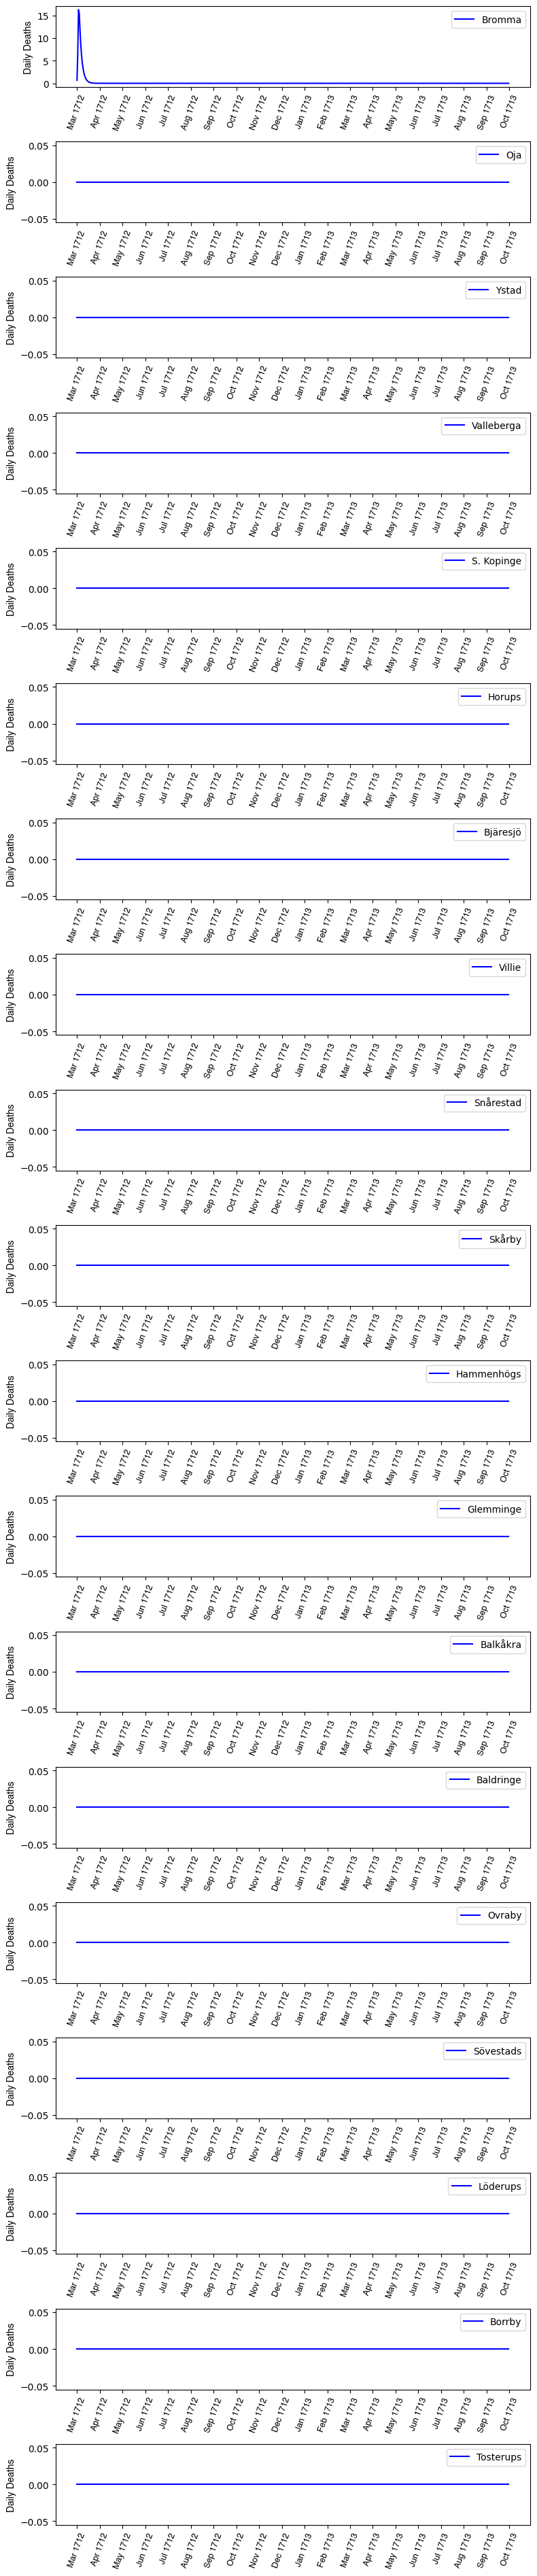

In [71]:
# Set the figsize for each subplot
figsize_single_subplot = (8, 2)

# Calculate the total figure height based on the number of subplots and their height
fig_height = figsize_single_subplot[1] * n

# Create a figure and an array of axes with nrows=n and ncols=1
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(
    figsize_single_subplot[0], fig_height))

tick_labels = ["Mar 1712", "Apr 1712", "May 1712", "Jun 1712", "Jul 1712", "Aug 1712", "Sep 1712", "Oct 1712", "Nov 1712", "Dec 1712", "Jan 1713", "Feb 1713", "Mar 1713", "Apr 1713", "May 1713", "Jun 1713", "Jul 1713", "Aug 1713", "Sep 1713", "Oct 1713"
               ]
tick_positions = [0, 30, 60, 90, 120, 150, 180, 210, 240,
                  270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570]


for i in range(n):
    # Plot daily deaths for each patch i
    axes[i].plot(daily_deaths(model_dict, i, 0, 570),
                 color='blue', label=(patchNames[i]))
    axes[i].set_ylabel('Daily Deaths', font='Helvetica')
    axes[i].legend(loc='upper right')
    axes[i].xaxis.set_ticks(tick_positions, tick_labels,
                            rotation=70, font='Helvetica', fontsize=9)

# Adjust the layout to avoid overlapping
plt.tight_layout()
plt.show()
